## 🧠 Physics-Informed Neural Network for the 3D Magnetic Induction Equation

This PINN implements the **kinematic dynamo model** studied by
**V. Archontis, S. B. F. Dorch, and Å. Nordlund (2003), _A&A 397, 393–399_**.
The governing equation is the **magnetic induction equation**:

$$
\frac{\partial \mathbf{B}}{\partial t}
= \nabla \times (\mathbf{u} \times \mathbf{B}),
\qquad \nabla \cdot \mathbf{B} = 0
$$

where
- **$ \mathbf{B}(x,y,z,t) = (B_x,B_y,B_z) $** is the magnetic field,
- **$ \mathbf{u}(x,y,z) $** is a prescribed incompressible velocity field

---

### ⚙️ Velocity Field
$$
\mathbf{u}_{ABC} =
\big(0,\;
u_0\sin(\pi z/2),\;
0\big),
$$

---
### ⚙️ Magnetic Field at t = 0

$$
B = (0, 0, B_0)
$$

---
### 🧩 PINN Architecture
- **Input:** spatial–temporal coordinates $(y, z, t)$
- **Output:** magnetic field components $(B_y, B_z)$
- **Network:** fully connected MLP with 4 hidden layers × 64 neurons
(activation: **Tanh**)
- **Loss function:**
  1. **PDE residual loss** enforcing
  $\partial_t \mathbf{B} - \nabla\times(\mathbf{u}\times\mathbf{B}) = 0$
  2. **Divergence-free loss** enforcing $\nabla\cdot\mathbf{B}=0$
  3. **Initial-condition loss** ensuring $\mathbf{B}(x,y,z,0)=\mathbf{B}_0(x,y,z)$
- **Optimizer:** Adam with StepLR scheduler (decay every 500 epochs)
- **Training points:**
  - Collocation points ($N_f$) sampled uniformly in the 4-D domain
  - Initial-condition points ($N_0$) at $t=0$
- **Domain:** $ x,y,z \in [0,2\pi] $, $t \in [0,T_{\text{max}}]$

---

### 📈 Physical Meaning
The network learns a magnetic field evolution that simultaneously:
- satisfies the **induction equation** everywhere in the domain,
- preserves **solenoidality** ($\nabla\cdot\mathbf{B}=0$),
- matches the **initial seed field** (small random perturbation).

This mimics the **kinematic dynamo regime**, where magnetic fields grow
exponentially through stretching and folding by the ABC flow,
as described in the reference paper.

---

### 📊 Visualization & Outputs
The training script plots:
- **Total loss** vs. epoch

---

### 🧾 Reference
Archontis V., Dorch S. B. F., Nordlund Å. (2003).
**"Numerical simulations of kinematic dynamo action."**

_Astronomy & Astrophysics_ [https://www.aanda.org/articles/aa/pdf/2003/02/aa2653.pdf](https://www.aanda.org/articles/aa/pdf/2003/02/aa2653.pdf)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PINN architecture

In [ ]:
# Neural Network for Magnetic Induction Equation (Vector B)

class PINN_Magnetic2D(nn.Module):
    def __init__(self, layers, dropout_prob=0.1):
        super(PINN_Magnetic2D, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        # PINNs often work better with smooth activations:
        # self.activation = nn.Tanh()
        self.activation = nn.ReLU()

    def forward(self, y, z, t):
        inp = torch.cat([y, z, t], dim=1)   # shape (N, 3)
        # apply all layers except the last (these are hidden layers)
        for layer in self.layers[:-1]:
            inp = self.activation(layer(inp))
        # final linear -> output layer (no activation)
        out = self.layers[-1](inp)
        return out  # shape (N, output_dim)


def to_tensor(x, requires_grad=False):
    return torch.tensor(x, dtype=torch.float32, device=device, requires_grad=requires_grad)



In [ ]:
# -------------------------
# Differential helpers
# -------------------------
def gradient(f, x):
    # returns df/dx with same shape as f
    return torch.autograd.grad(f, x, torch.ones_like(f), retain_graph=True, create_graph=True)[0]

# -------------------------
# PDE residual for induction eq
# -------------------------

def pde_residual(model, u0, y, z, t):
    y.requires_grad_(True)
    z.requires_grad_(True)
    t.requires_grad_(True)

    B = model(y, z, t)
    By, Bz = B[:, 0:1], B[:, 1:2]

    # time derivatives
    By_t = gradient(By, t)
    Bz_t = gradient(Bz, t)

    # velocity field: only uy(z)
    uy = u0 * torch.sin(z / 2)

    # u × B = (uy × B) = ?
    # u = (0, uy, 0), B = (0, By, Bz)
    uxB_x = uy * Bz  # (x-component)
    uxB_y = torch.zeros_like(uy)
    uxB_z = -uy * By

    # curl(u × B) in 2D (y,z)
    # curl_x = d(uxB_z)/dy - d(uxB_y)/dz
    # curl_y = d(uxB_x)/dz - d(uxB_z)/dx ≈ d(uxB_x)/dz
    # curl_z = d(uxB_y)/dx - d(uxB_x)/dy ≈ -d(uxB_x)/dy
    curl_y = gradient(uxB_x, z)
    curl_z = -gradient(uxB_x, y)

    fBy = By_t - curl_y
    fBz = Bz_t - curl_z
    divB = gradient(By, y) + gradient(Bz, z)
    return fBy, fBz, divB



In [ ]:
# -------------------------
# Velocity Field (u = u0 sin(z/2) ŷ)
# -------------------------
def velocity_field(x, y, z, u0):
    u0 = torch.tensor(u0, dtype=torch.float32, device=device)
    ux = torch.zeros_like(x)
    uy = u0 * torch.cos(np.pi*z / 2)
    uz = torch.zeros_like(x)
    return ux, uy, uz

In [ ]:
# -------------------------
# Problem hyperparams
# -------------------------
u0 = 1.0
B0 = 1.0


domain_min = -1
domain_max = 1
T_max = 5.0

N_f = 5000
N0  = 500
lr = 1e-3

# -------------------------
# Initial condition: B = (0, 0, B0)
# -------------------------
def initial_B(y, z, B0):
    return np.tile([0, B0], (len(y), 1))


# -------------------------
# Dataset (random collocation inside domain)
# -------------------------
def sample_domain(N, t_min=0.0, t_max=T_max):
    y = np.random.uniform(domain_min, domain_max, (N,1))
    z = np.random.uniform(domain_min, domain_max, (N,1))
    t = np.random.uniform(t_min, t_max, (N,1))
    return y, z, t


# initial IC points
y0_np, z0_np = (np.random.uniform(domain_min, domain_max, (N0,1)) for _ in range(2))
t0_np = np.zeros((N0,1))
B0_np = initial_B(y0_np, z0_np, B0)

# convert to tensors
y0_t = to_tensor(y0_np); z0_t = to_tensor(z0_np); t0_t = to_tensor(t0_np)
B0_t = to_tensor(B0_np)


In [ ]:
#  -------------------------
# Model, optimizer
# -------------------------
model = PINN_Magnetic2D([3, 128, 64, 32, 16, 8, 4, 2]).to(device)
# model = PINN_Magnetic2D([3, 64, 64, 2]).to(device)
# model = PINN_Magnetic2D([3, 64, 64, 64, 64, 2]).to(device)
# model = PINN_Magnetic2D([3, 128, 128, 128, 128, 2]).to(device)
# model = PINN_Magnetic2D([3, 64, 64, 64, 2], dropout_prob=0.05).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

# -------------------------
# Training loop
# -------------------------
loss_history = []
mag_energy_history = []
epochs = 20000  # training epochs


for ep in range(epochs):
    model.train()
    optimizer.zero_grad()
    # sample collocation points each epoch (physics-informed collocation)
    y_f_np, z_f_np, t_f_np = sample_domain(N_f)
    y_f = to_tensor(y_f_np, requires_grad=True)
    z_f = to_tensor(z_f_np, requires_grad=True)
    t_f = to_tensor(t_f_np, requires_grad=True)

    fBy, fBz, divB = pde_residual(model, u0, y_f, z_f, t_f)
    loss_pde = torch.mean(fBy**2 + fBz**2)

    loss_div = torch.mean(divB**2)

    B0_pred = model(y0_t, z0_t, t0_t)

    loss_ic = torch.mean((B0_pred - B0_t)**2)

    loss = loss_pde + loss_div + 10*loss_ic  # weights can be tuned
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())

    if ep % 250 == 0:
        print(f"[{ep:5d}] loss: {loss.item():.3e}  loss_pde:{loss_pde.item():.3e} loss_div:{loss_div.item():.3e} loss_ic:{loss_ic.item():.3e} lr: {scheduler.get_last_lr()[0]:.3e}")

[    0] loss: 6.920e+00  loss_pde:6.943e-03 loss_div:1.630e-06 loss_ic:6.913e-01 lr: 1.000e-03
[  250] loss: 8.785e-02  loss_pde:8.394e-02 loss_div:1.165e-03 loss_ic:2.742e-04 lr: 1.000e-03
[  500] loss: 8.263e-02  loss_pde:7.818e-02 loss_div:2.023e-03 loss_ic:2.429e-04 lr: 5.000e-04
[  750] loss: 8.007e-02  loss_pde:7.626e-02 loss_div:1.594e-03 loss_ic:2.216e-04 lr: 5.000e-04
[ 1000] loss: 8.288e-02  loss_pde:7.899e-02 loss_div:1.633e-03 loss_ic:2.259e-04 lr: 2.500e-04
[ 1250] loss: 8.187e-02  loss_pde:7.780e-02 loss_div:1.644e-03 loss_ic:2.426e-04 lr: 2.500e-04
[ 1500] loss: 6.123e-02  loss_pde:5.661e-02 loss_div:1.930e-03 loss_ic:2.688e-04 lr: 1.250e-04
[ 1750] loss: 2.268e-02  loss_pde:1.941e-02 loss_div:2.080e-03 loss_ic:1.192e-04 lr: 1.250e-04
[ 2000] loss: 1.152e-02  loss_pde:9.362e-03 loss_div:1.586e-03 loss_ic:5.676e-05 lr: 6.250e-05
[ 2250] loss: 1.210e-02  loss_pde:1.056e-02 loss_div:1.132e-03 loss_ic:4.071e-05 lr: 6.250e-05
[ 2500] loss: 1.149e-02  loss_pde:1.035e-02 loss_d

In [ ]:
path = "/content/drive/MyDrive/NN_Models"
m_name = "/2D_kinematic_dynamo_action_10k_[3, 128, 64, 32, 16, 8, 4, 2]-cos-Relu"
torch.save(model, path + m_name + ".pt")

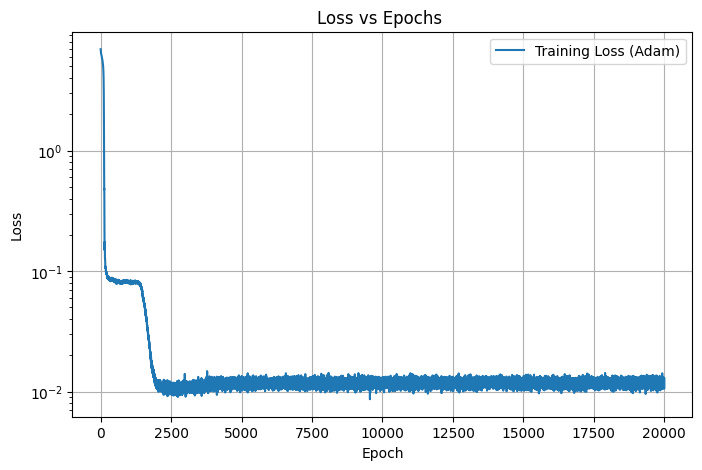

In [ ]:
# -----------------------------
# Plot loss
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(loss_history, label="Training Loss (Adam)")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs ")
plt.legend()
plt.grid(True)
plt.savefig(path + m_name + "_Loss.png")  # Save the plot as a PNG file
plt.show()

In [ ]:
# path = "/content/drive/MyDrive/NN_Models"
# m_name = "/2D_kinematic_dynamo_action_10k_64*4-hiddenlayers"
# model = torch.load(path + m_name + ".pt", weights_only=False)
# print(model.eval())

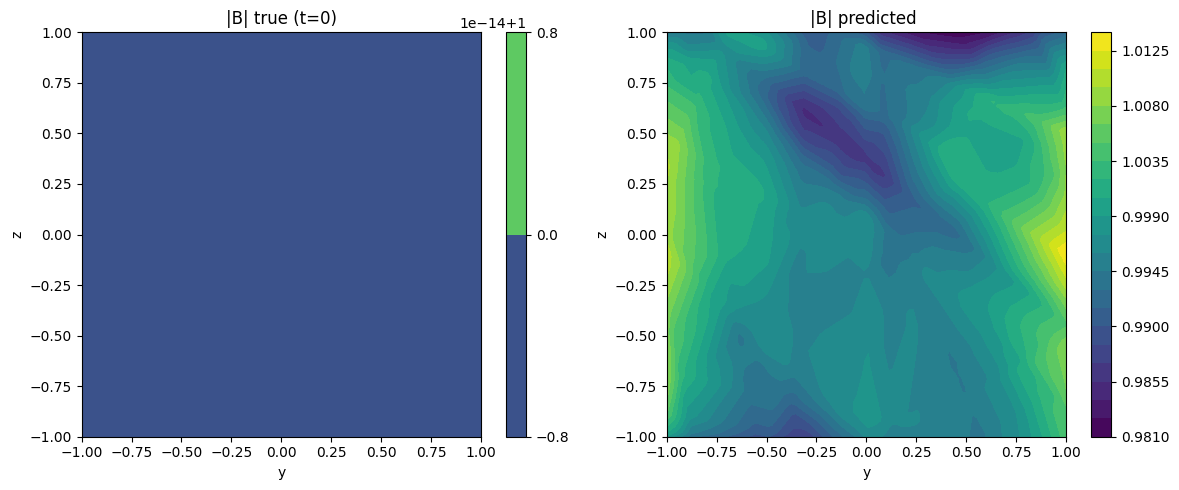

In [ ]:
# -------------------------
# Plot model vs. actual field at t = 0
# -------------------------
model.eval()
with torch.no_grad():
    Ny, Nz = 100, 100  # resolution of grid
    y_grid = np.linspace(domain_min, domain_max, Ny)
    z_grid = np.linspace(domain_min, domain_max, Nz)
    Y, Z = np.meshgrid(y_grid, z_grid)

    # Prepare tensors for model evaluation
    y_t = to_tensor(Y.flatten()[:, None])
    z_t = to_tensor(Z.flatten()[:, None])
    # t_t = torch.zeros_like(y_t) * t0
    t_t = torch.ones_like(y_t) * 0

    # Model prediction
    B_pred = model(y_t, z_t, t_t).cpu().numpy()
    By_pred, Bz_pred = B_pred[:, 0], B_pred[:, 1]
    Bmag_pred = np.sqrt(By_pred**2 + Bz_pred**2).reshape(Nz, Ny)

    # Actual (analytical initial condition)
    By_true = np.zeros_like(Y)
    Bz_true = np.ones_like(Y) * B0
    Bmag_true = np.sqrt(By_true**2 + Bz_true**2)

# -------------------------
# Plot
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cs1 = axes[0].contourf(Y, Z, Bmag_true, levels=30)
axes[0].set_title("|B| true (t=0)")
axes[0].set_xlabel("y")
axes[0].set_ylabel("z")
fig.colorbar(cs1, ax=axes[0])

cs2 = axes[1].contourf(Y, Z, Bmag_pred, levels=30)
axes[1].set_title("|B| predicted ")
axes[1].set_xlabel("y")
axes[1].set_ylabel("z")
fig.colorbar(cs2, ax=axes[1])

plt.tight_layout()
plt.show()


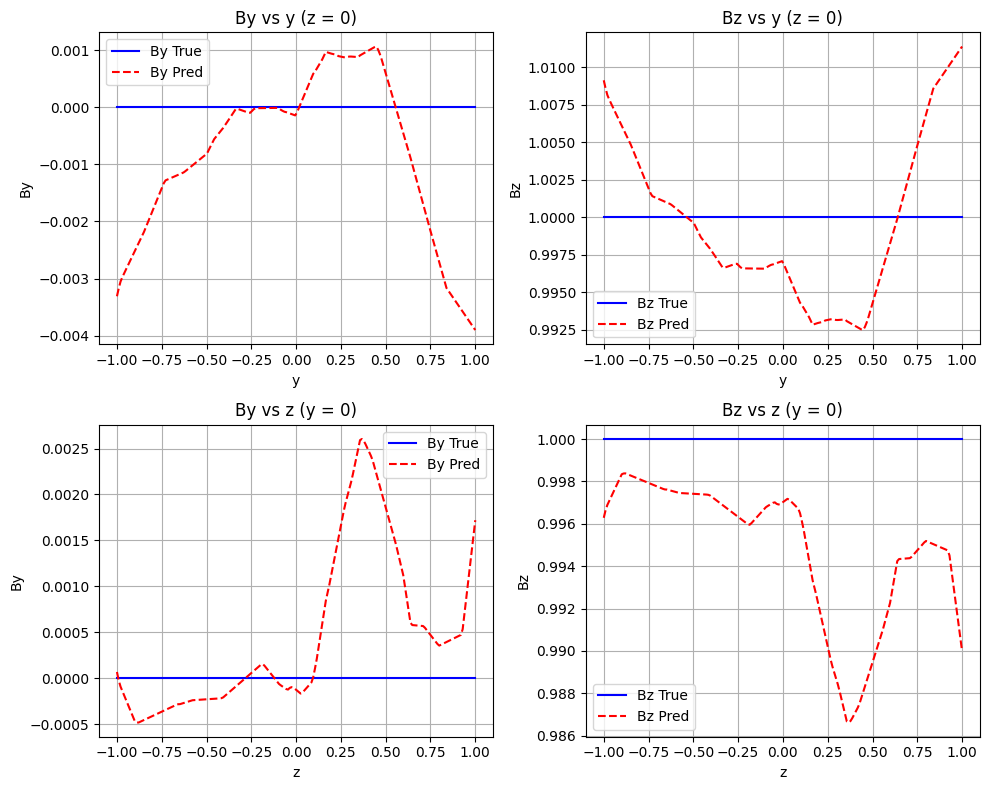

In [ ]:
# -------------------------
# 2×2 Subplot: Model vs True Field Components
# -------------------------
y0, z0 = 0, 0

y_line = np.linspace(domain_min, domain_max, 200)
z_line = np.linspace(domain_min, domain_max, 200)

# Prepare data for Bz vs y and By vs y
z_fixed = z0 * np.ones_like(y_line)
y_t = to_tensor(y_line[:, None])
z_t = to_tensor(z_fixed[:, None])
# t_t = torch.zeros_like(y_t)
t_t = torch.ones_like(y_t) * 0

with torch.no_grad():
    B_pred_y = model(y_t, z_t, t_t).detach().cpu().numpy()

By_pred_y, Bz_pred_y = B_pred_y[:, 0], B_pred_y[:, 1]
By_true_y = np.zeros_like(y_line)
Bz_true_y = np.ones_like(y_line) * B0

# Prepare data for Bz vs z and By vs z
y_fixed = y0 * np.ones_like(z_line)
y_t = to_tensor(y_fixed[:, None])
z_t = to_tensor(z_line[:, None])
t_t = torch.zeros_like(z_t)

with torch.no_grad():
    B_pred_z = model(y_t, z_t, t_t).detach().cpu().numpy()

By_pred_z, Bz_pred_z = B_pred_z[:, 0], B_pred_z[:, 1]
By_true_z = np.zeros_like(z_line)
Bz_true_z = np.ones_like(z_line) * B0

# -------------------------
# Plot 2×2 grid
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Top-left → By vs y
axes[0, 0].plot(y_line, By_true_y, 'b-', label='By True')
axes[0, 0].plot(y_line, By_pred_y, 'r--', label='By Pred')
axes[0, 0].set_xlabel("y"); axes[0, 0].set_ylabel("By")
axes[0, 0].set_title(f"By vs y (z = {z0})")
axes[0, 0].legend(); axes[0, 0].grid(True)

# Top-right → Bz vs y
axes[0, 1].plot(y_line, Bz_true_y, 'b-', label='Bz True')
axes[0, 1].plot(y_line, Bz_pred_y, 'r--', label='Bz Pred')
axes[0, 1].set_xlabel("y"); axes[0, 1].set_ylabel("Bz")
axes[0, 1].set_title(f"Bz vs y (z = {z0})")
axes[0, 1].legend(); axes[0, 1].grid(True)

# Bottom-left → By vs z
axes[1, 0].plot(z_line, By_true_z, 'b-', label='By True')
axes[1, 0].plot(z_line, By_pred_z, 'r--', label='By Pred')
axes[1, 0].set_xlabel("z"); axes[1, 0].set_ylabel("By")
axes[1, 0].set_title(f"By vs z (y = {y0})")
axes[1, 0].legend(); axes[1, 0].grid(True)

# Bottom-right → Bz vs z
axes[1, 1].plot(z_line, Bz_true_z, 'b-', label='Bz True')
axes[1, 1].plot(z_line, Bz_pred_z, 'r--', label='Bz Pred')
axes[1, 1].set_xlabel("z"); axes[1, 1].set_ylabel("Bz")
axes[1, 1].set_title(f"Bz vs z (y = {y0})")
axes[1, 1].legend(); axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


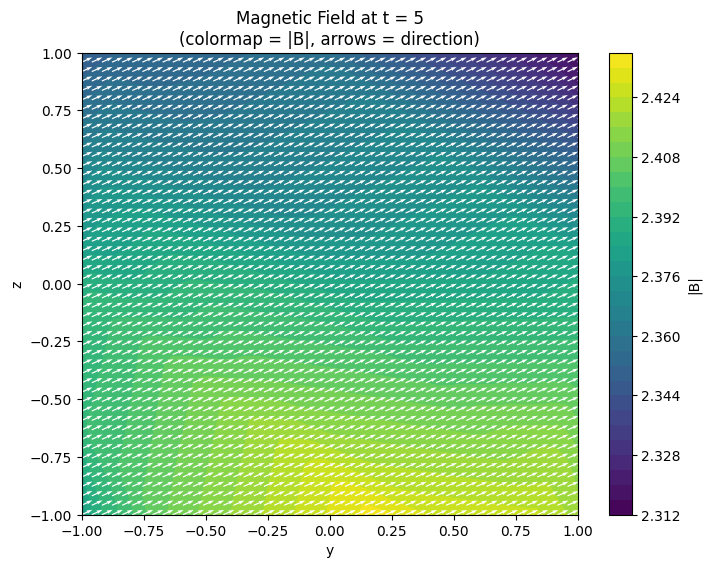

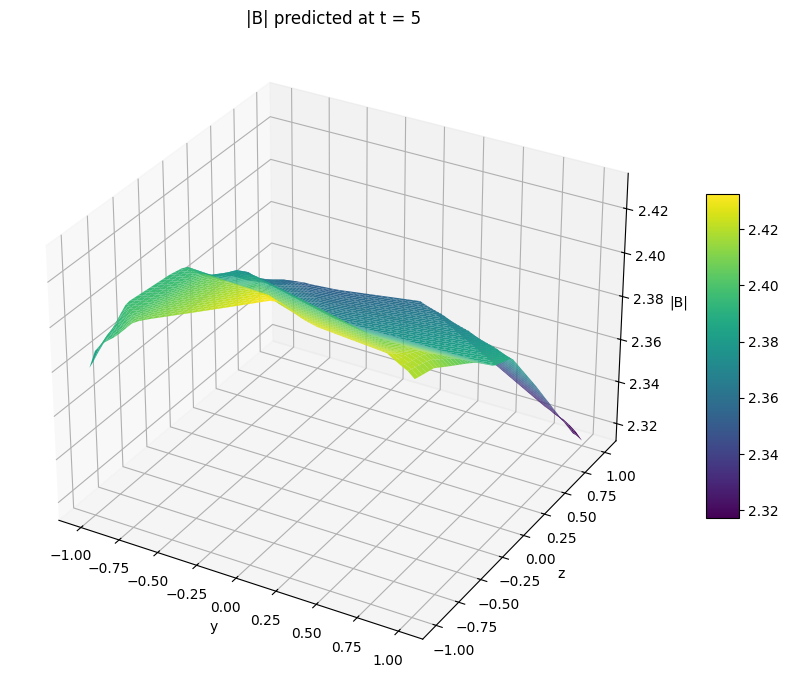

In [ ]:
# -------------------------
# PINN model at t = t0
# -------------------------
t0 = 5

# Evaluate model on a grid
Ny, Nz = 50, 50   # quiver looks cleaner with fewer arrows
y_grid = np.linspace(domain_min, domain_max, Ny)
z_grid = np.linspace(domain_min, domain_max, Nz)
Y, Z = np.meshgrid(y_grid, z_grid)

y_tq = to_tensor(Y.flatten()[:, None])
z_tq = to_tensor(Z.flatten()[:, None])
t_tq = torch.ones_like(y_tq) * t0   # time t0

with torch.no_grad():
    B_pred_q = model(y_tq, z_tq, t_tq).cpu().numpy()

By_q = B_pred_q[:, 0].reshape(Nz, Ny)
Bz_q = B_pred_q[:, 1].reshape(Nz, Ny)

# magnitude field
Bmag_q = np.sqrt(By_q**2 + Bz_q**2)

# -------------------------
# 2D quiver + colormap
# -------------------------
plt.figure(figsize=(8, 6))

plt.contourf(Y, Z, Bmag_q, levels=30, cmap="viridis")
plt.colorbar(label="|B|")
plt.quiver(Y, Z, By_q, Bz_q, color="white", scale=100)

plt.title(f"Magnetic Field at t = {t0}\n(colormap = |B|, arrows = direction)")
plt.xlabel("y")
plt.ylabel("z")
plt.grid(False)
plt.show()

# -------------------------
# 3D surface plot
# -------------------------
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    Y, Z, Bmag_q,
    rstride=1, cstride=1,
    linewidth=0,
    antialiased=True,
    cmap='viridis'
)

ax.set_title(f"|B| predicted at t = {t0}")
ax.set_xlabel("y")
ax.set_ylabel("z")
# ax.set_zlim(0,2)
ax.set_zlabel("|B|")

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()
